# **Obtenemos los datos**

In [2]:
import pandas as pd
import requests
import csv

import matplotlib.pyplot as plt
%matplotlib inline
symbol = 'BTCUSDT' #Podemos reemplazar el symbolo por el par de criptos que deseemos
tick_interval = '1d'

In [3]:
def get_candles(start='', symbol='BTCUSDT', tick_interval='1d', limit=1000):
    base_url = 'https://api.binance.com/'
    endpoint = 'api/v3/klines?'
    
    if start:
        query = 'symbol=' + symbol + '&interval=' + tick_interval + '&startTime=' + str(start) +'&limit='+str(limit)
    else:
        query = 'symbol=' + symbol + '&interval=' + tick_interval +'&limit='+str(limit)
        
    candles = requests.get(base_url + endpoint + query).json()
    
    return candles, candles[-1][6]

In [4]:
def get_all_candles_from_start(symbol, tick_interval):  # devuelve una lista de velas, cada vela es una lista tb
    start=1502942400000  # 17 de agosto de 2017
    _, last_time = get_candles(start='', symbol=symbol , tick_interval=tick_interval, limit=1)
    candles = []
    
    while start < last_time:
        i_candles, next_hop = get_candles(start, symbol, tick_interval)
        candles = candles + i_candles
        start = next_hop
    return candles

In [5]:
candles = get_all_candles_from_start(symbol, tick_interval)
columns=['open_time','open', 'high', 'low','close','volume','close_time','quote','trades','takers_buy_base','takers_buy_quote','ignore']
df = pd.DataFrame(candles, columns=columns)

In [6]:
df = df.sort_values('close_time')
df.drop_duplicates(keep='last')
df = df.astype(float)

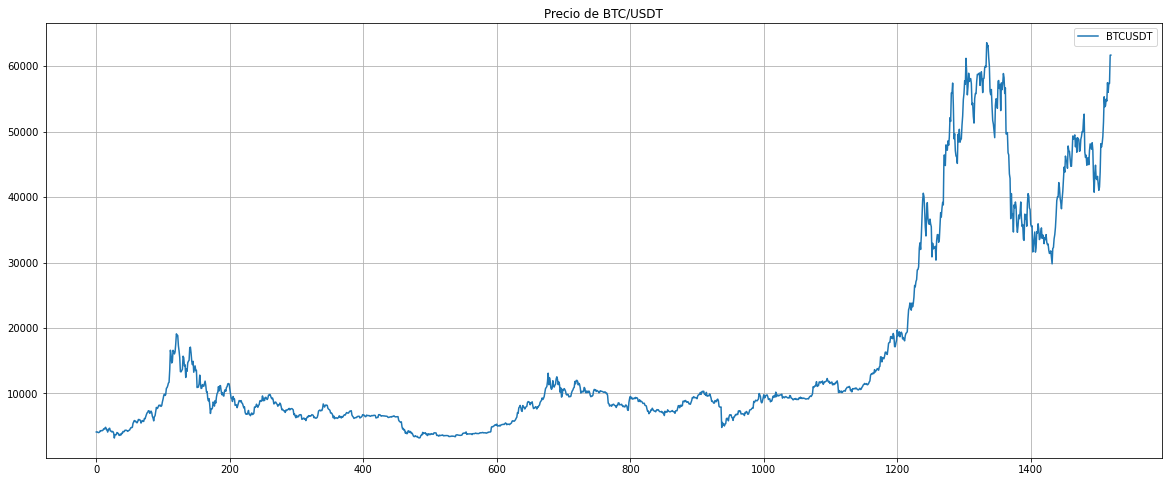

In [7]:
df['close'].plot(figsize=(20,8), label='BTCUSDT')
plt.title('Precio de BTC/USDT')
plt.legend()
plt.grid()

In [8]:
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df['close_time'] = df['close_time'].dt.tz_localize('utc').dt.tz_convert('America/Argentina/Catamarca')

In [9]:
close_time = df['close_time'].astype(str)
close_time = close_time.str.split(':').str[0]
close_time = close_time.str.split(' ').str[0]
close_time

0       2017-08-18
1       2017-08-19
2       2017-08-20
3       2017-08-21
4       2017-08-22
           ...    
1516    2021-10-12
1517    2021-10-13
1518    2021-10-14
1519    2021-10-15
1520    2021-10-16
Name: close_time, Length: 1521, dtype: object

In [10]:
df = df.drop(columns='close_time')
df['close_time'] = close_time
# df = df.set_index('close_time')
df

,open_time,open,high,low,close,volume,quote,trades,takers_buy_base,takers_buy_quote,ignore,close_time
0,1.503014e+12,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233.0,972.868710,4.129123e+06,9384.141409,2017-08-18
1,1.503101e+12,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153.0,274.336042,1.118002e+06,9184.085529,2017-08-19
2,1.503187e+12,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321.0,376.795947,1.557401e+06,10125.414084,2017-08-20
3,1.503274e+12,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972.0,557.356107,2.255663e+06,11706.769970,2017-08-21
4,1.503360e+12,4016.00,4104.82,3400.00,4040.00,966.684858,3.752506e+06,6494.0,423.995181,1.637188e+06,11773.279500,2017-08-22
...,...,...,...,...,...,...,...,...,...,...,...,...
1516,1.633997e+12,57471.35,57680.00,53879.00,55996.93,53471.285500,3.017211e+09,1554412.0,26157.442470,1.477084e+09,0.000000,2021-10-12
1517,1.634083e+12,55996.91,57777.00,54167.19,57367.00,55808.444920,3.123308e+09,1610489.0,27985.132070,1.566812e+09,0.000000,2021-10-13
1518,1.634170e+12,57370.83,58532.54,56818.05,57347.94,43053.336781,2.481916e+09,1372048.0,21940.264979,1.265138e+09,0.000000,2021-10-14
1519,1.634256e+12,57347.94,62933.00,56850.00,61672.42,82512.908022,4.959389e+09,2649137.0,43913.676331,2.638970e+09,0.000000,2021-10-15


In [11]:
df.to_csv(f'{symbol}_{tick_interval}.csv',index=False,header=True, quoting=csv.QUOTE_ALL)
# from google.colab import files  # to download data from colab
# files.download('BTCUSDT_1d.csv')

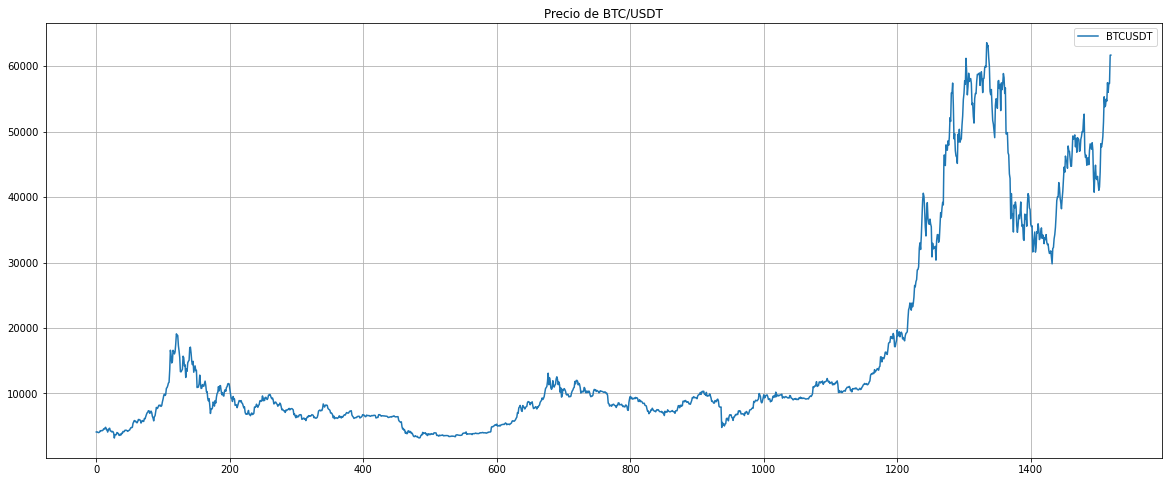

In [12]:
df['close'].plot(figsize=(20,8), label='BTCUSDT')
plt.title('Precio de BTC/USDT')
plt.legend()
plt.grid()

# **Modelo predictivo**

In [13]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('/content/BTCUSDT_1d.csv', index_col='close_time')
dataset

,open_time,open,high,low,close,volume,quote,trades,takers_buy_base,takers_buy_quote,ignore
close_time,,,,,,,,,,,
2017-08-18,1.503014e+12,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233.0,972.868710,4.129123e+06,9384.141409
2017-08-19,1.503101e+12,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153.0,274.336042,1.118002e+06,9184.085529
2017-08-20,1.503187e+12,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321.0,376.795947,1.557401e+06,10125.414084
2017-08-21,1.503274e+12,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972.0,557.356107,2.255663e+06,11706.769970
2017-08-22,1.503360e+12,4016.00,4104.82,3400.00,4040.00,966.684858,3.752506e+06,6494.0,423.995181,1.637188e+06,11773.279500
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-12,1.633997e+12,57471.35,57680.00,53879.00,55996.93,53471.285500,3.017211e+09,1554412.0,26157.442470,1.477084e+09,0.000000
2021-10-13,1.634083e+12,55996.91,57777.00,54167.19,57367.00,55808.444920,3.123308e+09,1610489.0,27985.132070,1.566812e+09,0.000000
2021-10-14,1.634170e+12,57370.83,58532.54,56818.05,57347.94,43053.336781,2.481916e+09,1372048.0,21940.264979,1.265138e+09,0.000000


In [14]:
set_entrenamiento = dataset[:'2021'].iloc[:,2:3]
set_validacion = dataset['2021':].iloc[:,2:3]

In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [16]:
time_step = 240
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

from keras.models import Sequential
from keras.layers import LSTM, Dense

dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 60

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=100,batch_size=15)

x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Epoch 1/100
67/67 [==============================] - 10s 43ms/step - loss: 0.0035
Epoch 2/100
67/67 [==============================] - 3s 44ms/step - loss: 0.0010
Epoch 3/100
67/67 [==============================] - 3s 43ms/step - loss: 7.9710e-04
Epoch 4/100
67/67 [==============================] - 3s 44ms/step - loss: 6.4118e-04
Epoch 5/100
67/67 [==============================] - 3s 43ms/step - loss: 5.5230e-04
Epoch 6/100
67/67 [==============================] - 3s 43ms/step - loss: 4.5509e-04
Epoch 7/100
67/67 [==============================] - 3s 43ms/step - loss: 4.7681e-04
Epoch 8/100
67/67 [==============================] - 3s 43ms/step - loss: 3.8736e-04
Epoch 9/100
67/67 [==============================] - 3s 44ms/step - loss: 3.6608e-04
Epoch 10/100
67/67 [==============================] - 3s 44ms/step - loss: 3.3009e-04
Epoch 11/100
67/67 [==============================] - 3s 44ms/step - loss: 3.2651e-04
Epoch 12/100
67/67 [==============================] - 3s 44ms/step - l

In [17]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

In [18]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la Criptomoneda')
    plt.plot(prediccion, color='blue', label='Predicción de la Criptomoneda')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la Criptomoneda')
    plt.rcParams["figure.figsize"] = (15,8)
    plt.legend()
    plt.show()

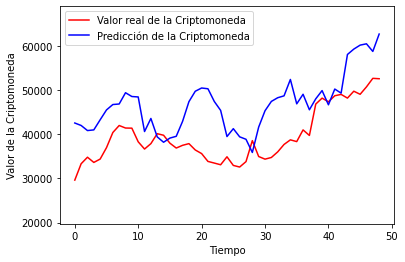

In [19]:
graficar_predicciones(set_validacion.values,prediccion)

# **Alphacast**

In [20]:
!pip install alphacast

In [21]:
from alphacast import Alphacast
alphacast = Alphacast('ak_JfHRRcvvlfnEGAK8YXta')

In [22]:
alphacast.repository.read_all()

[{'accountId': 708,
  'description': 'You can use you first public repository to share content with the community',
  'id': 1002,
  'name': 'My Public Repo',
  'permission': 'Owner',
  'privacy': 'Public',
  'slug': 'public-repo'},
 {'accountId': 708,
  'description': 'Escrapeos y transformación de datos realizados por el Licenciado en Economía Juan Pablo Benitez para la vacante laboral Data Analyst',
  'id': 1243,
  'name': 'Vacante Data Analyst',
  'permission': 'Owner',
  'privacy': 'Private',
  'slug': 'vacante-data-analyst'},
 {'accountId': 708,
  'description': 'Repositorio para el puesto DAta Analyst',
  'id': 1245,
  'name': 'Repo Juan Benitez',
  'permission': 'Owner',
  'privacy': 'Public',
  'slug': 'repo-juan-benitez'},
 {'accountId': 708,
  'description': 'Repositorio para el puesto Data Analyst',
  'id': 1246,
  'name': 'Repo Juan Benitez1',
  'permission': 'Owner',
  'privacy': 'Public',
  'slug': 'repo-juan-benitez1'}]

In [23]:
alphacast.repository.create("Repo Data Analyst", repo_description="Repositorio para el puesto Data Analyst", privacy="Public", returnIdIfExists=True)

{'description': 'Repositorio para el puesto Data Analyst',
 'id': 1249,
 'name': 'Repo Data Analyst',
 'privacy': 'Public',
 'slug': 'repo-data-analyst'}

In [24]:
alphacast.datasets.create('Histórico Criptos', 1249, 'Scrapping de datos históricos del par BTC/USDT')

{'createdAt': '2021-10-16T03:40:19.097035',
 'id': 8105,
 'name': 'Histórico Criptos',
 'repositoryId': 1249}

In [27]:
df1 = dataset[['high','low','close','trades']]
df1 = df1.reset_index()
df1['close_time'] = pd.to_datetime(df1['close_time'])
df1

,close_time,high,low,close,trades
0,2017-08-18,4371.52,3938.77,4108.37,5233.0
1,2017-08-19,4184.69,3850.00,4139.98,2153.0
2,2017-08-20,4211.08,4032.62,4086.29,2321.0
3,2017-08-21,4119.62,3911.79,4016.00,3972.0
4,2017-08-22,4104.82,3400.00,4040.00,6494.0
...,...,...,...,...,...
1516,2021-10-12,57680.00,53879.00,55996.93,1554412.0
1517,2021-10-13,57777.00,54167.19,57367.00,1610489.0
1518,2021-10-14,58532.54,56818.05,57347.94,1372048.0
1519,2021-10-15,62933.00,56850.00,61672.42,2649137.0


In [28]:
df = df1[['close_time','high','low','close']]

In [31]:
alphacast.datasets.dataset(8105).initialize_columns(dateColumnName ="close_time", entitiesColumnNames=["high","low","close","trades"], dateFormat= "%Y-%m-%d")

b'{"id": 8105, "columnDefinitions": [{"sourceName": "close_time", "dataType": "Date", "dateFormat": "%Y-%m-%d", "isEntity": "True"}, {"sourceName": "high", "isEntity": "True"}, {"sourceName": "low", "isEntity": "True"}, {"sourceName": "close", "isEntity": "True"}, {"sourceName": "trades", "isEntity": "True"}], "updateAt": "2021-10-16T03:41:46.591566"}'

In [32]:
alphacast.datasets.dataset(8105).upload_data_from_df(df1, deleteMissingFromDB = False, onConflictUpdateDB = False, uploadIndex=True)

b'{"id": 54841, "status": "Requested", "createdAt": "2021-10-16T03:41:49.711328", "datasetId": 8105}'